In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [6]:
import numpy as np
import tensorflow as tf
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [7]:
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, GlobalAveragePooling2D, Dense, Multiply, Reshape, SeparableConv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model

# Channel Attention Module
def channel_attention(x, filters, ratio=16):
    avg_pool = GlobalAveragePooling2D()(x)
    fc1 = Dense(filters // ratio, activation='relu')(avg_pool)
    fc2 = Dense(filters, activation='sigmoid')(fc1)
    scale = Multiply()([x, Reshape((1, 1, filters))(fc2)])  # Reshape and multiply
    return scale

# Residual Block with Channel Attention
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = channel_attention(res, filters)  # Apply attention
    res = Lambda(lambda t: t * scaling)(res)  # Scale residual output
    return Add()([x, res])  # Skip connection

# Create RCAN Model
def create_rcan():
    input_img = Input(shape=(80, 145, 1))  # Modified input shape

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(input_img)
    # initial_conv = LeakyReLU(alpha=0.2)(initial_conv)

    # Residual Blocks with Channel Attention
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    # Final Conv Layer (Reduces to 1 Output Channel)
    x = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    x = Add()([x, initial_conv])

    # Upsampling Layer moved to the end
    x = UpSampling2D(size=(2, 2))(x)  # Upscale to (160, 290)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam',
                  loss='mae',
                  metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [8]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 80, 145, 1)
(21478, 160, 290, 1)
(4602, 80, 145, 1)
(4602, 160, 290, 1)


In [ ]:
# Initialize the model
rcan_model = create_rcan()
rcan_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80, 145, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 145, 32)    │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 80, 145, 32)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ conv2d_2[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │             96 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 80, 145, 32)    │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 80, 145, 32)    │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 80, 145, 32)    │              0 │ conv2d[0][0],          │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ conv2d_4[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 75,530 (295.04 KB)

 Trainable params: 75,530 (295.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 49s 177ms/step - loss: 0.0310 - mae: 0.0310 - mse: 0.0038 - psnr: 26.8927 - ssim: 0.8170 - val_loss: 0.0102 - val_mae: 0.0102 - val_mse: 4.9129e-04 - val_psnr: 33.0880 - val_ssim: 0.9365 - learning_rate: 0.0010
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0093 - mae: 0.0093 - mse: 3.9606e-04 - psnr: 34.0581 - ssim: 0.9415 - val_loss: 0.0081 - val_mae: 0.0081 - val_mse: 2.8879e-04 - val_psnr: 35.3948 - val_ssim: 0.9492 - learning_rate: 0.0010
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0081 - mae: 0.0081 - mse: 2.7384e-04 - psnr: 35.6315 - ssim: 0.9504 - val_loss: 0.0076 - val_mae: 0.0076 - val_mse: 2.3141e-04 - val_psnr: 36.3567 - val_ssim: 0.9533 - learning_rate: 0.0010
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.0076 - mae: 0.0076 - mse: 2.2437e-04 - psnr: 36.4934 - ssim: 0.9538 - val_loss: 0.0073 - val_mae: 0.0073 - val_mse: 2.0193e-04 - val_psnr: 36.9484 - val_ssim: 0.9553 - learn

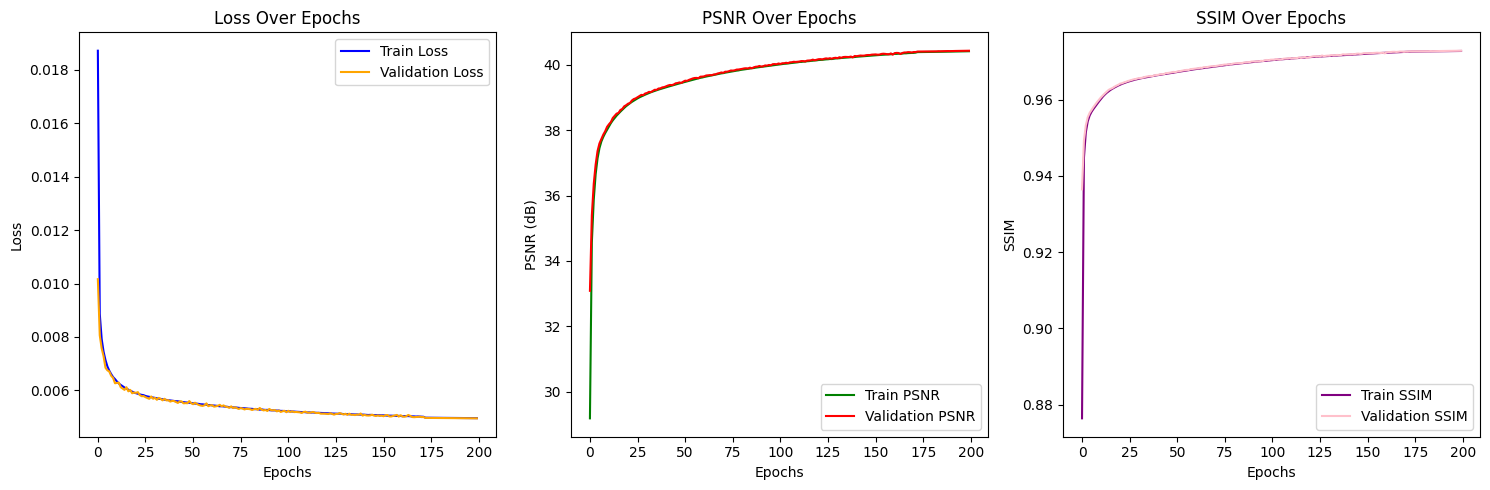

In [ ]:
import time

start_time = time.time()
history = train_model(rcan_model, trainX, trainY, valX, valY, 200, 128, True, True, 50, 40)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")


plot_history(history)
save_model(rcan_model, 'models/rcan_model_1to0_5_deg_200epochs.keras')

In [11]:
rcan_model = tf.keras.models.load_model('models/rcan_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [12]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = rcan_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0050 - mae: 0.0050 - mse: 9.1522e-05 - psnr: 40.3868 - ssim: 0.9725
Test Loss: 0.004981248639523983
Test PSNR: 40.38397216796875
Test SSIM: 0.9725637435913086
Test MSE: 9.158247848972678e-05
Test MAE: 0.004981247708201408


In [13]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = rcan_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


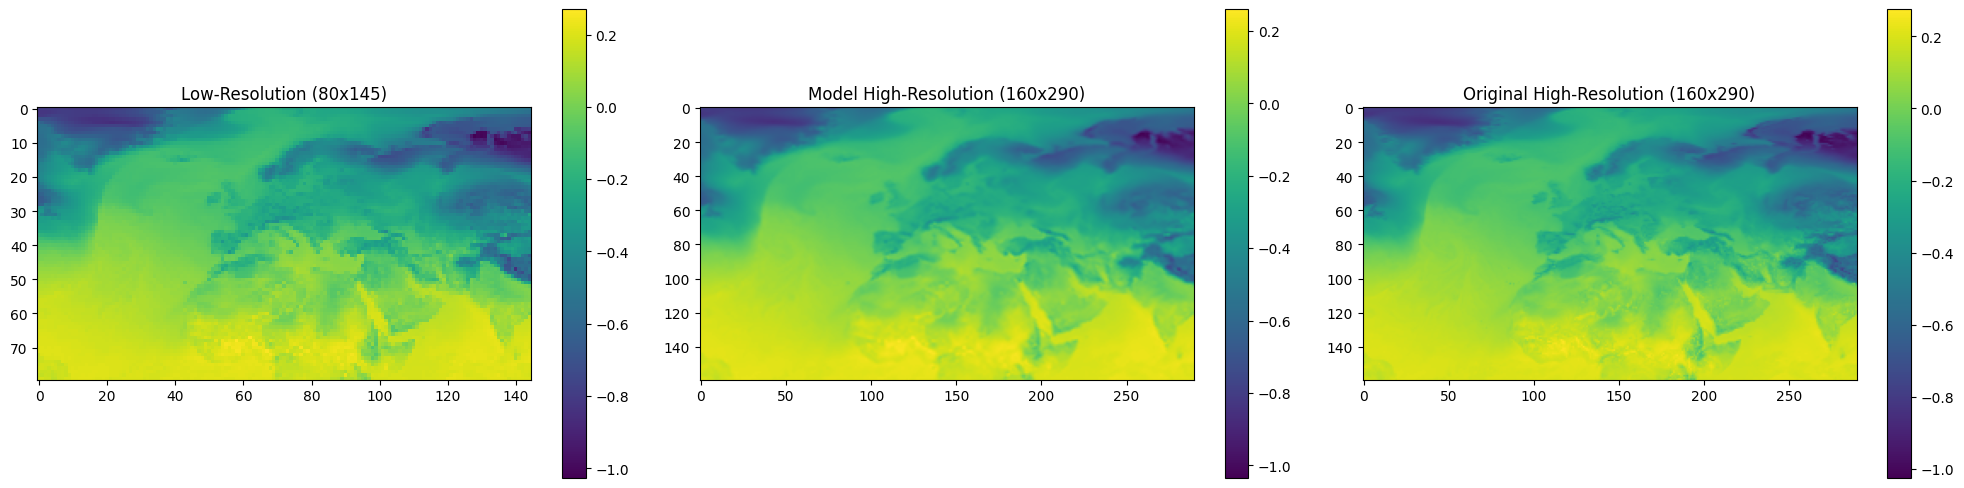

In [14]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

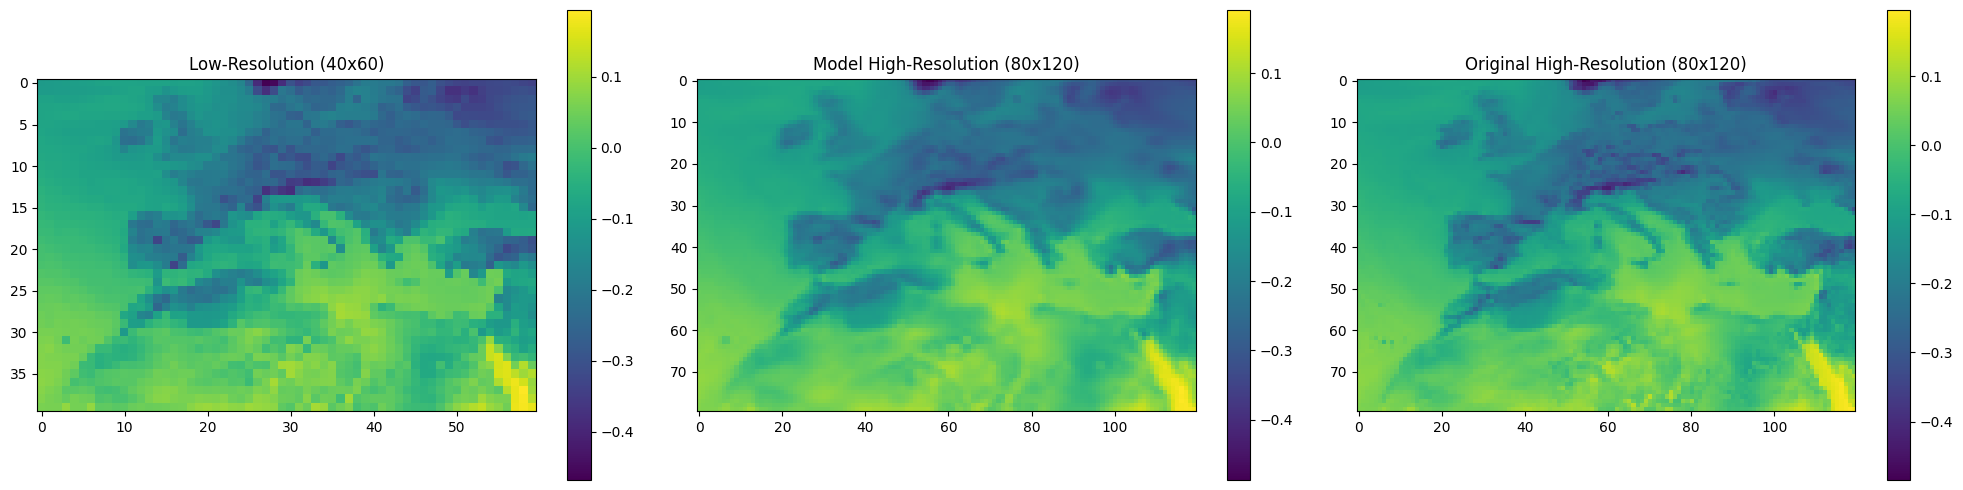

In [15]:
plot_to_compare(low_res_input[20:60, 40:100], np.squeeze(high_res_data)[40:120, 80:200],  np.squeeze(high_res_output)[40:120, 80:200], 'viridis')

In [16]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(rcan_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Per-pixel MSE shape: (160, 290, 1)
Per-pixel MAE shape: (160, 290, 1)
Per-pixel PSNR shape: (160, 290, 1)
Per-pixel SSIM shape: (160, 290, 1)
Mean Per-Pixel MSE: 9.158246e-05
Mean Per-Pixel MAE: 0.0049812472
Mean Per-Pixel PSNR: 46.860912
Mean Per-Pixel SSIM: 0.9887518


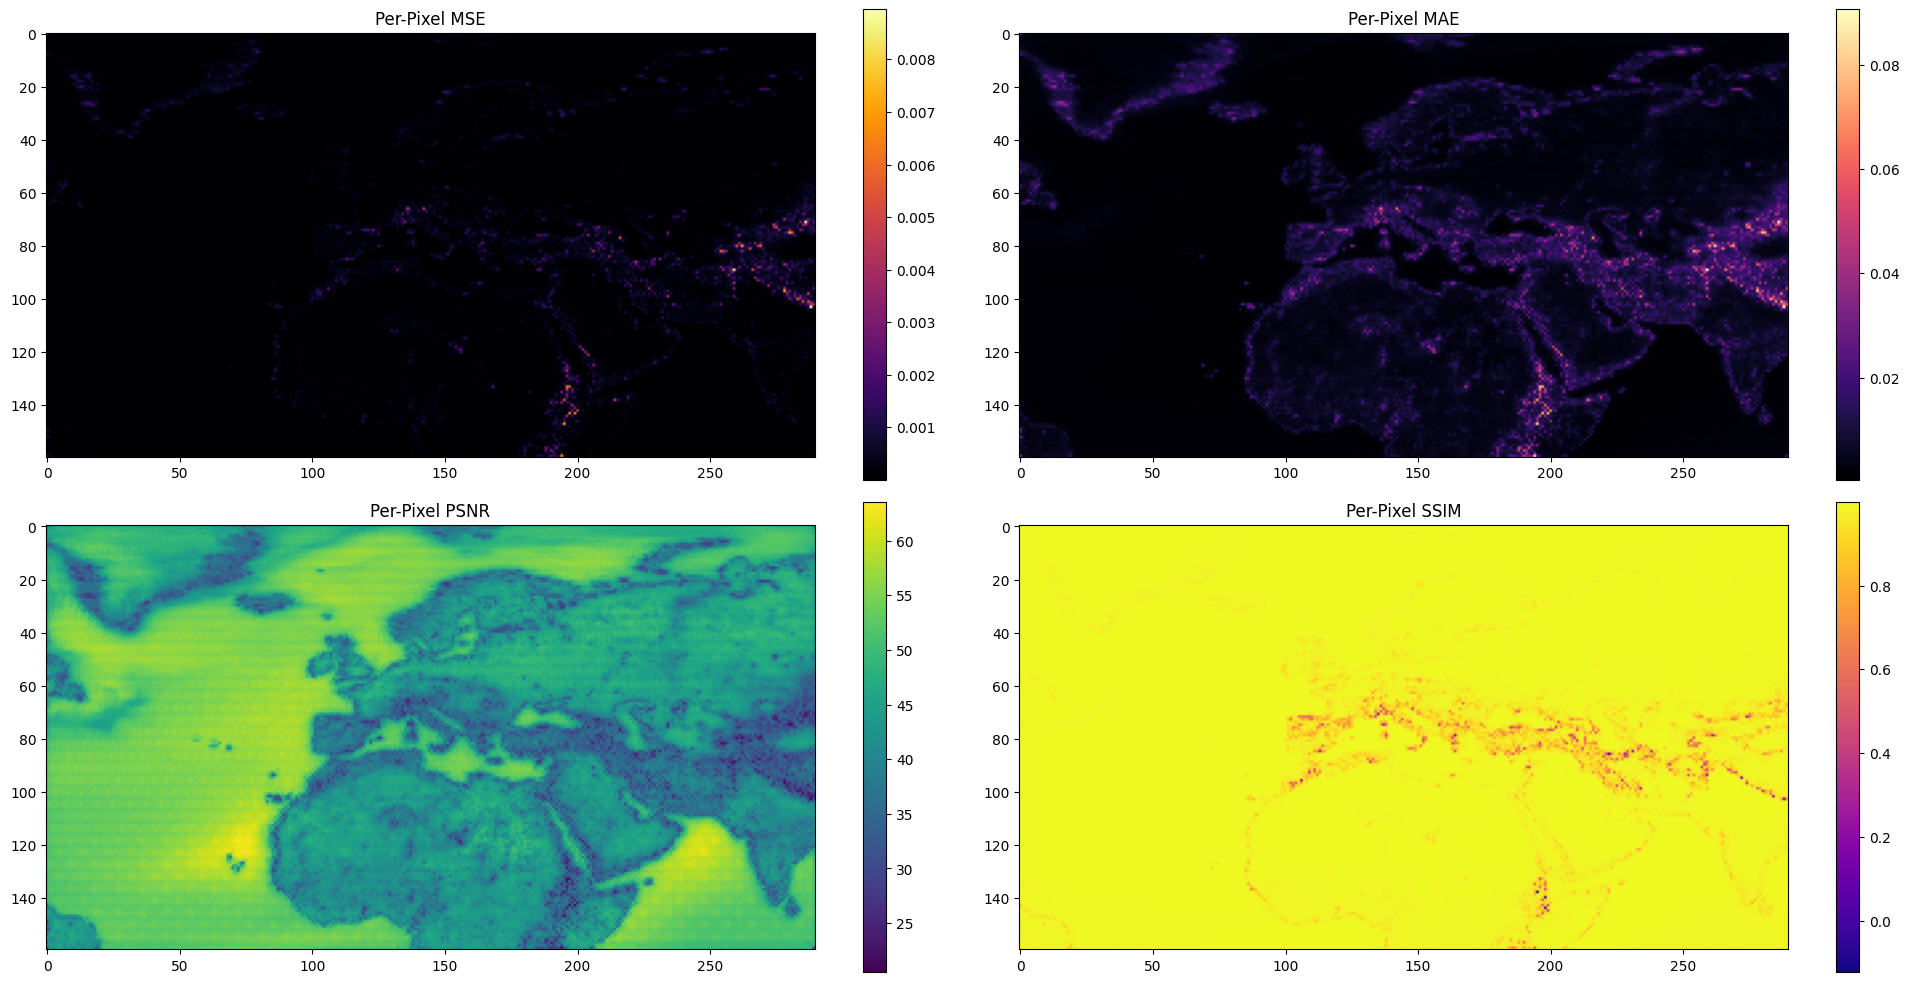

In [17]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.32007906
Max Degrees MAE: 5.8196187
Min Degrees MAE: 0.028701274


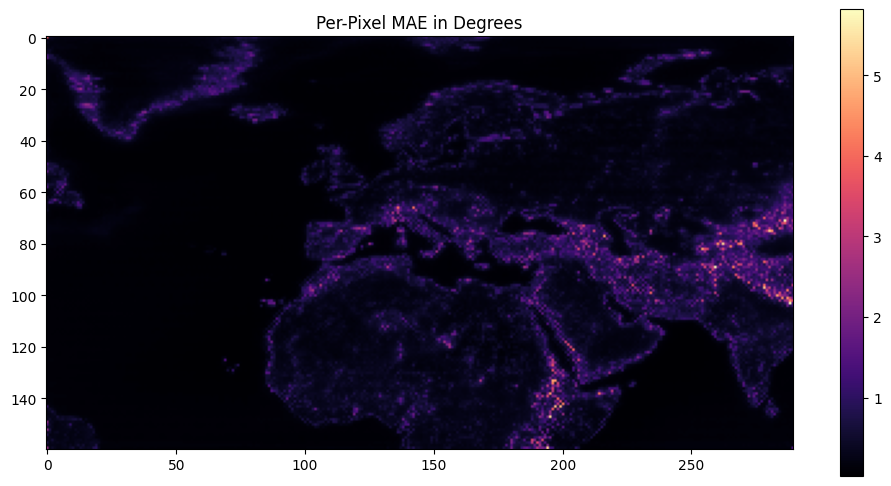

In [18]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [19]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_5'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_5'))

Mean Land-Pixels Degrees MAE: 0.49381843
Mean Land-Pixels MAE: 0.0076850764


In [20]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_5'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_5'))

Mean Coastline-Pixels Degrees MAE: 0.7001184
Mean Costline-Pixels MAE: 0.01089563
